In [11]:
import quandl
QUANDL_API_KEY='yzcRLefPxvrTHdJ6_WPT'
quandl.ApiConfig.api_key=QUANDL_API_KEY

## Detrend by Removing Mean

In [12]:
df=quandl.get('CHRIS/CME_GC1',column_index=6,collapse='monthly',start_date='2000-01-01')

In [13]:
df.head()

,Settle
Date,
2000-01-31,283.2
2000-02-29,294.2
2000-03-31,278.4
2000-04-30,274.7
2000-05-31,271.7


In [14]:
df_settle=df['Settle'].resample('MS').ffill().dropna()
df_rolling=df_settle.rolling(12)
df_mean=df_rolling.mean()
df_std=df_rolling.std()

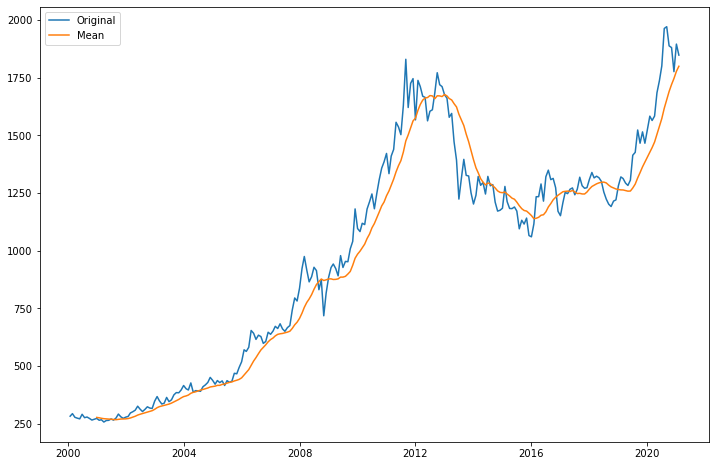

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(df_settle,label='Original')
plt.plot(df_mean,label='Mean')
plt.legend();

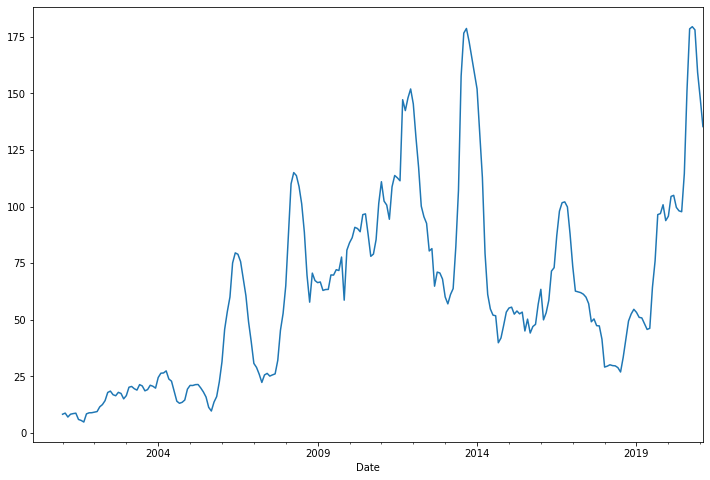

In [16]:
df_std.plot(figsize=(12,8));

In [17]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df_settle)
print('ADF stat:',result[0])
print('p=value:',result[1])
critical_values=result[4]
for key,value in critical_values.items():
    print('Critical value (%s): %.3f' % (key,value))

ADF stat: -0.7651275382245423
p=value: 0.8291516334245652
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


In [18]:
result

(-0.7651275382245423,
 0.8291516334245652,
 11,
 241,
 {'1%': -3.4577787098622674,
  '5%': -2.873608704758507,
  '10%': -2.573201765981991},
 2563.2738573268603)

In [19]:
import numpy as np
df_log=np.log(df_settle)
df_log_ma=df_log.rolling(2).mean()
df_detrend=df_log-df_log_ma
df_detrend.dropna(inplace=True)

In [20]:
df_detrend_rolling=df_detrend.rolling(12)
df_detrend_ma=df_detrend_rolling.mean()
df_detrend_std=df_detrend_rolling.std()

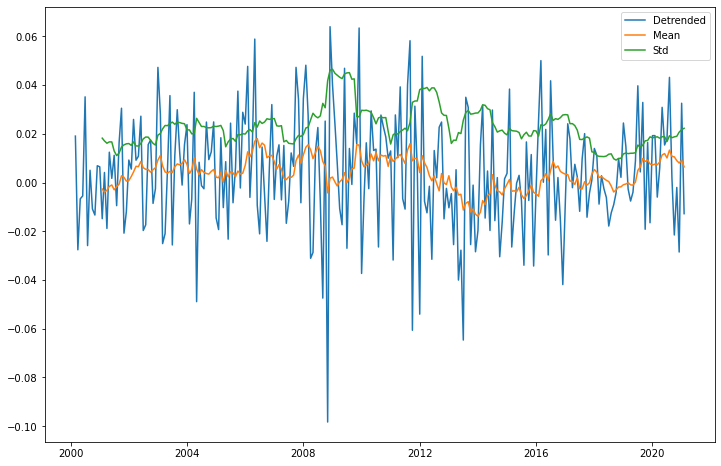

In [21]:
plt.figure(figsize=(12,8))
plt.plot(df_detrend,label='Detrended')
plt.plot(df_detrend_ma,label='Mean')
plt.plot(df_detrend_std,label='Std')
plt.legend(loc='upper right');

## ADF Test for Stationary

In [22]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df_detrend)
print('ADF stat:',result[0])
print('p=value: %.5f' % result[1])
critical_values=result[4]
for key,value in critical_values.items():
    print('Critical value (%s): %.3f' % (key,value))

ADF stat: -17.941732535125688
p=value: 0.00000
Critical value (1%): -3.457
Critical value (5%): -2.873
Critical value (10%): -2.573


## Detrend by Differencing

In [23]:
df_log_diff=df_log.diff(periods=3).dropna()
df_diff_rolling=df_log_diff.rolling(12)
df_diff_ma=df_diff_rolling.mean()
df_diff_std=df_diff_rolling.std()

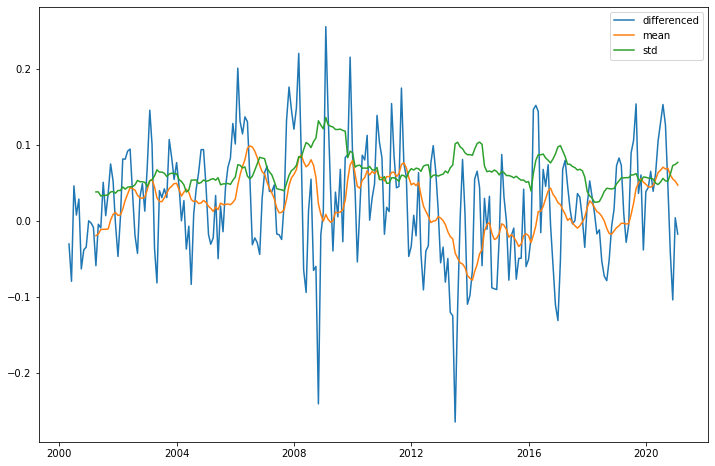

In [24]:
plt.figure(figsize=(12,8))
plt.plot(df_log_diff,label='differenced')
plt.plot(df_diff_ma,label='mean')
plt.plot(df_diff_std,label='std')
plt.legend(loc='upper right');

<AxesSubplot:xlabel='Date'>

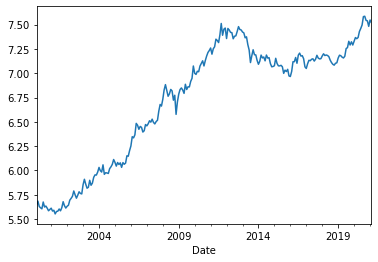

In [25]:
df_log.plot()

<AxesSubplot:xlabel='Date'>

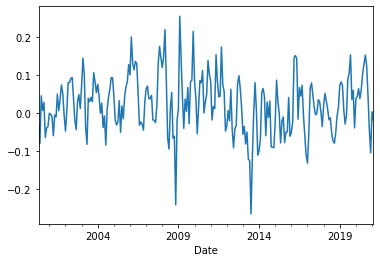

In [26]:
df_log_diff.plot()

In [27]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df_log_diff)
print('ADF stat:',result[0])
print('p=value: %.5f' % result[1])
critical_values=result[4]
for key,value in critical_values.items():
    print('Critical value (%s): %.3f' % (key,value))

ADF stat: -3.308278802086628
p=value: 0.01451
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


## Seasonal Decomposing

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result=seasonal_decompose(df_log.dropna(),period=12)
df_trend=decompose_result.trend
df_season=decompose_result.seasonal
df_residual=decompose_result.resid

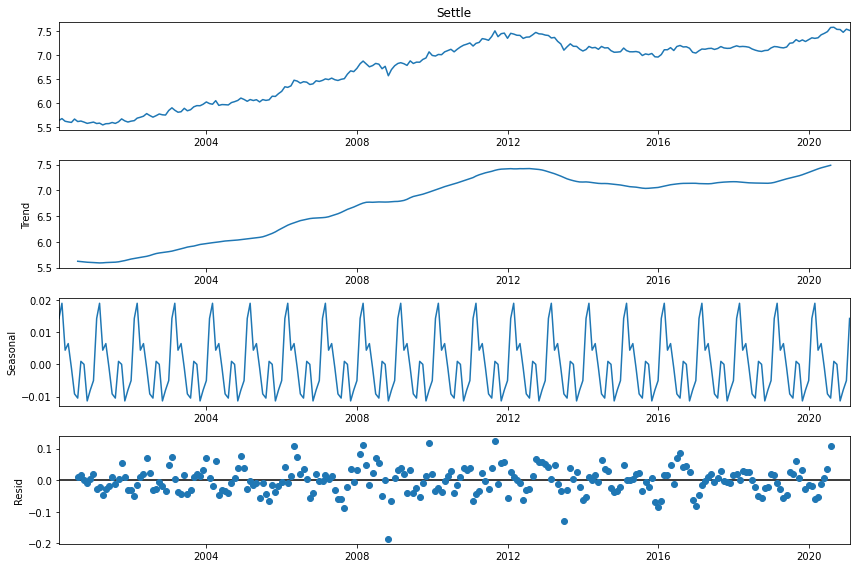

In [29]:
plt.rcParams['figure.figsize']=(12,8)
fig=decompose_result.plot()

In [30]:
df_log_diff=df_residual.diff().dropna()
df_diff_rolling=df_log_diff.rolling(12)
df_diff_ma=df_diff_rolling.mean()
df_diff_std=df_diff_rolling.std()

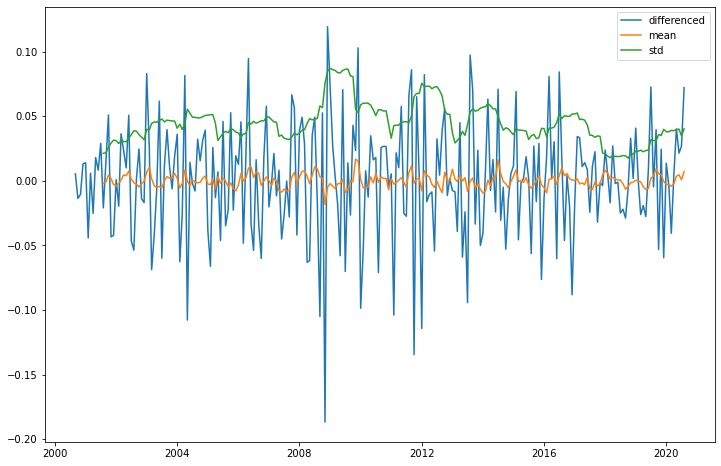

In [31]:
plt.figure(figsize=(12,8))
plt.plot(df_log_diff,label='differenced')
plt.plot(df_diff_ma,label='mean')
plt.plot(df_diff_std,label='std')
plt.legend();

In [32]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df_residual.dropna())
print('ADF stat:',result[0])
print('p=value: %.5f' % result[1])
critical_values=result[4]
for key,value in critical_values.items():
    print('Critical value (%s): %.3f' % (key,value))

ADF stat: -6.8653241332772454
p=value: 0.00000
Critical value (1%): -3.459
Critical value (5%): -2.874
Critical value (10%): -2.574


## Predicting with ARIMA model

In [33]:
# fitting parameters by grid search

In [34]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [39]:
def arima_grid_search(dataframe,s):
    p=d=q=range(2)
    param_combinations=list(itertools.product(p,d,q))
    lowest_aic,pdq,pdqs=None,None,None
    total_iterations=0
    for order in param_combinations:
        for (p,q,d) in param_combinations:
            seasonal_order=(p,q,d,s)
            total_iterations+=1
            try:
                model=SARIMAX(df_settle,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,
                             enforce_invertibility=False,disp=False)
                model_result=model.fit(maxiter=200,disp=False)
                
                if not lowest_aic or model_result.aic<lowest_aic:
                    lowest_aic=model_result.aic
                    pdq,pdqs=order,seasonal_order
            except Exception as ex:
                continue
    return lowest_aic,pdq,pdqs

In [40]:
# call monthly data to find optimal hyperparameters p,d,q,s
lowest_aic,order,seasonal_order=arima_grid_search(df_settle,12)
print('ARIMA{}x{}'.format(order,seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA(0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 2485.971


In [43]:
# fitting the SARIMAX model
model=SARIMAX(df_settle,order=order,seasonal_order=seasonal_order,enforce_stationary=False,enforce_invertability=False,disp=False)
model_results=model.fit(maxiter=200,disp=False)
print(model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Settle   No. Observations:                  253
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1313.146
Date:                            Mon, 22 Feb 2021   AIC                           2632.291
Time:                                    07:18:01   BIC                           2642.733
Sample:                                02-01-2000   HQIC                          2636.499
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1410      0.042     -3.398      0.001      -0.222      -0.060
ma.S.L12      -0.9085      0.071   

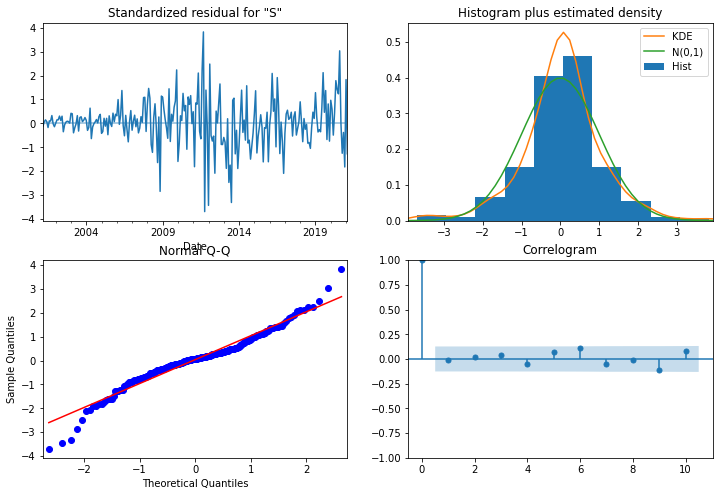

In [45]:
model_results.plot_diagnostics(figsize=(12,8));

In [46]:
# KDE plot duggests that errors are Gaussian distribution
model_results.resid.describe()

count    253.000000
mean       2.643375
std       58.053377
min     -206.130086
25%      -22.628519
50%        4.098465
75%       25.960251
max      283.200000
dtype: float64

In [47]:
# none-zero mean suggests that prediction may be positively baised

## Predicting with SARIMAX model

In [50]:
## using past 5-year data to predict next 5-month data
n=len(df_settle.index)
prediction=model_results.get_prediction(start=n-12*5,end=n+5)
prediction_ci=prediction.conf_int()
print(prediction_ci.head(3))

            lower Settle  upper Settle
2016-03-01   1009.645821   1226.618819
2016-04-01   1097.641156   1314.610263
2016-05-01   1124.038883   1341.007912


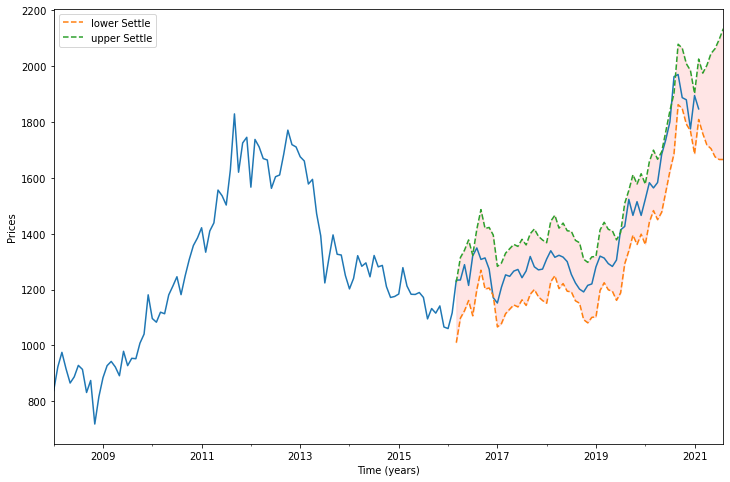

In [51]:
# compare predicted prices against original dataset - from 2008 onwards
plt.figure(figsize=(12,8))
ax=df_settle['2008':].plot(label='actual')
prediction_ci.plot(ax=ax,style=['--', '--'],label='predicted/forecasted')
ci_index=prediction_ci.index
lower_ci=prediction_ci.iloc[:, 0]
upper_ci=prediction_ci.iloc[:, 1]
ax.fill_between(ci_index,lower_ci,upper_ci,color='r',alpha=0.1)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')
plt.show()


In [52]:
# prediction is bounded by confidence interval. As we go into the future, the interval widens due to the loss of uncertainty.